<h4 align="right"> May 2020</h4>
<h1 align="center">Into to Data Analysis Final Project</h1>
<h2 align="center">Fairness in Classification on the COMPAS dataset</h2> <br>

**Team members:** \\
Christophe EL-ZEINATY \\
Youhana MIKHAIEL

##(1) Utils

###Imports

In [1]:
import urllib
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
from scipy import interp
from itertools import cycle
from statistics import mean
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

!pip install 'aif360[all]'

import aif360.datasets as ad
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

###Helper functions

In [0]:
#To get unique values in certain attribute
def get_unique(data,att):
  column_values = data[att].values.ravel()
  unique_values =  pd.unique(column_values)
  return unique_values

#compute number of days between two string dates (yyyy-mm-dd)
def compute_num_days(s1,s2):
  date1 = date(int(s1[0:4]),int(s1[5:7]),int(s1[8:10]))
  date2 = date(int(s2[0:4]),int(s2[5:7]),int(s2[8:10]))
  delta = date2-date1
  return delta.days

#returns number of days between two date attributes in dataframe (c_jail_in,c_jail_out)
def compute_days_series(data):
  num_days = []
  for i in range(data.shape[0]):
    s1 = data["c_jail_in"].iloc[i]
    s2 = data["c_jail_out"].iloc[i]
    if type(s1) is str and type(s2) is str:
      num_days = num_days + [compute_num_days(s1,s2)]
    else:
      num_days = num_days + [None]
  return num_days

#Encode categorical data to one-hot encoding scheme
def enc_cat_attr(data2,col):
  attr_values = get_unique(data2,col)
  if len(attr_values) > 2:
    for i in attr_values:
      data2[col+'_'+str(i)] = data2[col] == i
    data2 = data2.drop([col],axis=1)
  else:
    enc = preprocessing.LabelEncoder()
    data2[col] = enc.fit_transform(data2[col])
  data_cols = []
  for i in data2.columns:
    if i != 'two_year_recid':
      data_cols = data_cols + [i]
  data_cols = data_cols + ['two_year_recid']
  return data2[data_cols]

#plot acc and loss during training MLP
def plot_acc(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  no_epochs = len(history.history['loss'])

  plt.figure(figsize=(11,3))
  plt.subplot(121)
  plt.plot(range(1,no_epochs+1),loss)
  plt.plot(range(1,no_epochs+1),val_loss)
  plt.xlabel("Number of epochs")
  plt.ylabel("Loss")
  plt.legend(['train loss','val loss'])
  plt.subplot(122)
  plt.plot(range(1,no_epochs+1),acc)
  plt.plot(range(1,no_epochs+1),val_acc)
  plt.xlabel("Number of epochs")
  plt.ylabel("Accuracy")
  plt.legend(['train acc','val acc'])

#compute Accuracies and False Positive Rates FPR for each race
def compute_fpr(ypred,ytest):
  n_total = ypred.shape[0]
  corr = np.count_nonzero(ypred == ytest)
  acc = corr/n_total
  n_total_test_neg = np.count_nonzero(ytest == 0)
  if n_total_test_neg == 0:
    fpr = float('nan')
  else:
    fp = np.count_nonzero((ypred == 1) & (ytest == 0))
    fpr = fp/n_total_test_neg
  return acc, fpr

#Reject Option Classification function
def ROC_postprocess(dataset_train,dataset_valid,dataset_test,model,unpriv,priv):
  pos_ind = np.where(model.classes_ == dataset_train.favorable_label)[0][0]
  xvalid_data = dataset_valid.features
  yvalid_data = dataset_valid.labels

  xtest_data = dataset_test.features
  ytest_data = dataset_test.labels

  dataset_valid_pred = dataset_valid.copy(deepcopy=True)
  y_valid = dataset_valid_pred.labels
  dataset_valid_pred.scores = model.predict_proba(xvalid_data)[:,pos_ind].reshape(-1,1)

  dataset_test_pred = dataset_test.copy(deepcopy=True)
  y_test = dataset_test_pred.labels
  dataset_test_pred.scores = model.predict_proba(xtest_data)[:,pos_ind].reshape(-1,1)

  num_thresh = 100
  ba_arr = np.zeros(num_thresh)
  class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

  for idx, class_thresh in enumerate(class_thresh_arr):
    fav_inds = dataset_valid_pred.scores > class_thresh
    dataset_valid_pred.labels[fav_inds] = dataset_valid_pred.favorable_label
    dataset_valid_pred.labels[~fav_inds] = dataset_valid_pred.unfavorable_label
    classified_metric_orig_valid = ClassificationMetric(dataset_valid, dataset_valid_pred, unprivileged_groups=unpriv, privileged_groups=priv)
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate() + classified_metric_orig_valid.true_negative_rate())

  best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
  best_class_thresh = class_thresh_arr[best_ind]

  #print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
  #print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

  # Metric used to measure fairness
  metric_name = "Statistical parity difference"

  # Upper and lower bound on the fairness metric used
  metric_ub = 0.05
  metric_lb = -0.05

  ROC = RejectOptionClassification(unprivileged_groups=unpriv,privileged_groups=priv,low_class_thresh=0.01, high_class_thresh=0.99,num_class_thresh=100, 
                                   num_ROC_margin=50,metric_name=metric_name,metric_ub=metric_ub, metric_lb=metric_lb)
  ROC = ROC.fit(dataset_valid, dataset_valid_pred)
  #print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
  return ROC, dataset_valid_pred

def draw_roc(ypred,ytest,xtest):
  ypred = ypred.reshape((-1,1))
  ytest = ytest.reshape((-1,1))
  args_priv = np.argwhere(xtest[:,1]==1)
  args_unpriv = np.argwhere(xtest[:,1]==0)
  ypred_priv = ypred[args_priv].reshape((-1,1))
  ypred_unpriv = ypred[args_unpriv].reshape((-1,1))
  ytest_priv = ytest[args_priv].reshape((-1,1))
  ytest_unpriv = ytest[args_unpriv].reshape((-1,1))
  fpr_priv, tpr_priv, thre_priv = roc_curve(ytest_priv, ypred_priv)
  fpr_unpriv, tpr_unpriv, thre_unpriv = roc_curve(ytest_unpriv, ypred_unpriv)
  plt.plot(fpr_priv,tpr_priv)
  plt.plot(fpr_unpriv,tpr_unpriv)
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.legend(['Caucasian privilied roc curve','Non-Caucasian unprivilied roc curve','Random roc curve'])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC curves of priviliged and unpriviliged groups')
  plt.show()


###Download data

In [3]:
SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


## (2) Dataset Preprocessing & Cleaning

###Importing data & viewing NULL values statistics
We first see that the dataset has 7214 instances with 53 columns. \\
After that, we print how much NULLs each column has in percentage.

In [4]:
#Import data
data = pd.read_csv(COMPAS_INPUT_FILE)

#Display dataset size
data_size = data.shape
print("The dataset has %d columns and %d instances" %(data_size[1],data_size[0]))

#Get information about number of NULLs in each feature
print("Percentage of NULLs in each feature has: ")
data_nulls = data.isnull().sum()/data_size[0]
print(data_nulls)

The dataset has 53 columns and 7214 instances
Percentage of NULLs in each feature has: 
id                         0.000000
name                       0.000000
first                      0.000000
last                       0.000000
compas_screening_date      0.000000
sex                        0.000000
dob                        0.000000
age                        0.000000
age_cat                    0.000000
race                       0.000000
juv_fel_count              0.000000
decile_score               0.000000
juv_misd_count             0.000000
juv_other_count            0.000000
priors_count               0.000000
days_b_screening_arrest    0.042556
c_jail_in                  0.042556
c_jail_out                 0.042556
c_case_number              0.003050
c_offense_date             0.160660
c_arrest_date              0.842390
c_days_from_compas         0.003050
c_charge_degree            0.000000
c_charge_desc              0.004020
is_recid                   0.000000
r_case_numbe

###Dropping bad columns and/or bad instances
1. Dropping columns which has more than 0.5 of its instance values as NULL \\
2. Copying scores columns and then dropping them from the dataset \\
3. Copying two_year_recid label column \\
4. Dropping duplicate columns (decile_score, priors_count) \\
5. Dropping irrelevant columns to the training setup (id,name,is_recid,dob,c_case_number....etc) \\

After doing this, we can see that our dataset now has 11 columns (10 features and 1 label) with the same number of 7214 instances. Then we re-print the how much NULLs each column has in percentage. \\
We can see that there are two attributes still have missing values (c_jail_in, c_jail_out). 


In [5]:
#Drop column features that has many NULLs
data_original = data1.copy()

#dropping features that more than 50% of them are NULL
for i in data_nulls.keys():
  if data_nulls[i] > 0.5:
    data = data.drop(i,axis=1)

#extracting scores columns separately and dropping them from main dataframe
c_scores = data[["decile_score","score_text","v_decile_score","v_score_text"]]
data = data.drop(["decile_score","score_text","v_decile_score","v_score_text"],axis=1)

#extracting labels column separately and drop it from main dataframe
y_labels = data["two_year_recid"]
#data = data.drop(["two_year_recid"],axis=1)

#Removing duplicated attribute columns
data = data.drop(["decile_score.1","priors_count.1","is_recid"],axis=1)

#dropping features that are not important for the classification task
data = data.drop(["id","name","first","last","dob","age","c_case_number","v_screening_date", "v_type_of_assessment","type_of_assessment",
                  "compas_screening_date","days_b_screening_arrest","is_violent_recid","c_charge_desc","screening_date","in_custody",
                  "out_custody","start","end","event","c_offense_date","c_days_from_compas"],axis=1)

data_size = data.shape
print("The dataset has %d columns and %d instances" %(data_size[1],data_size[0]))
data_nulls = data.isnull().sum()/data_size[0]
print(data_nulls)

The dataset has 11 columns and 7214 instances
sex                0.000000
age_cat            0.000000
race               0.000000
juv_fel_count      0.000000
juv_misd_count     0.000000
juv_other_count    0.000000
priors_count       0.000000
c_jail_in          0.042556
c_jail_out         0.042556
c_charge_degree    0.000000
two_year_recid     0.000000
dtype: float64


In [6]:
data.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_jail_in,c_jail_out,c_charge_degree,two_year_recid
0,Male,Greater than 45,Other,0,0,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,F,0
1,Male,25 - 45,African-American,0,0,0,0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,1
2,Male,Less than 25,African-American,0,0,1,4,2013-04-13 04:58:34,2013-04-14 07:02:04,F,1
3,Male,Less than 25,African-American,0,1,0,1,NaN,NaN,F,0
4,Male,25 - 45,Other,0,0,0,2,NaN,NaN,F,0


In [7]:
#dropping instances that have more than 50% of their features are NULL
datacc = (data.isnull().sum(axis=1)/data_size[1]) > 0.50
datacc2 = dict(filter(lambda el: el[1] == True,datacc.items()))
if not len(datacc2):
  print("No instances were dropped")

No instances were dropped


###Manipulating existing features
1. We calculate the number of days the person has spent in jail (num_jail_days) from the dates (c_jail_in and c_jail_out) while replacing the NULL instances with NULL. \\
2. We take the average number of jail days of each class (two_year_recid=0, two_year_recid=1) \\
3. We change the NULL values in num_jail_days for each instance to have the value of the average of all instances with the same class. \\

In [0]:
#adding new attribute corresponds to number of days spent in jail
data['num_jail_days'] = pd.Series(compute_days_series(data))

#dropping c_jail_in and c_jail_out attributes
data = data.drop(["c_jail_in","c_jail_out"],axis=1)

In [9]:
#Filling in missing data for num_jail_days by averaging those with the same label class
mean_days_recid = int(data.loc[data['two_year_recid'] == 1].num_jail_days.mean())
mean_days_no_recid = int(data.loc[data['two_year_recid'] == 0].num_jail_days.mean())

data['num_jail_days'][(data['num_jail_days'].isnull()) & (data['two_year_recid'] == 1)] = mean_days_recid 
data['num_jail_days'][(data['num_jail_days'].isnull()) & (data['two_year_recid'] == 0)] = mean_days_no_recid  

data_no_encoding = data.copy()

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid,num_jail_days
0,Male,Greater than 45,Other,0,0,0,0,F,0,1.0
1,Male,25 - 45,African-American,0,0,0,0,F,1,10.0
2,Male,Less than 25,African-American,0,0,1,4,F,1,1.0
3,Male,Less than 25,African-American,0,1,0,1,F,0,13.0
4,Male,25 - 45,Other,0,0,0,2,F,0,13.0


###Encoding categorical features
1. For reasons that we will mention in the analysis part, we decided to have only two race categories (**Caucasian**, **non-Caucasian**) \\
2. We start encoding the nominal binary attributes (**sex**, **race**, **c_charge_degree**) by assigning 1 to value while assigning 0 to the other value. \\
3. Then, we encoded the nominal multi-labled attributes (**age_cat**) \\
4. We divided the continuous attributes into three categories, turning it to categorical attributes. \\
5. We do one-hot encoding to the multi-labeled attributes resulting in having more attributes (when priors_count categories are 0, 1 and 2, we have three new attributes (**priors_count_0**,**priors_count_1**,**priors_count_2**) and each of these new attributes has the value either 1 or 0 depending if the instance belongs to this attribute category or not). \\
This happens to these attributes (**priors_count**, **num_jail_days**, **juv_fel_counts**, **juv_misd_counts**, juv_other_counts). \\

At the end, we have a dataset with 15 features and 7214 instances.

In [11]:
#encoding nominal data
attr_t = {'sex':'Male', 'race':'Caucasian', 'c_charge_degree':'M'}
for i in attr_t.keys():
  data[i][data[i] != attr_t[i]] = 0
  data[i][data[i] == attr_t[i]] = 1

#encoding 'priors_count' where n=0 is class 0, n=1,2 is class 1 and n>2 is class 2
data['priors_count'][data['priors_count']==0] = 0
data['priors_count'][(data['priors_count']>0) & (data['priors_count']<=2)] = 1
data['priors_count'][data['priors_count']>2] = 2

#encoding 'age_cat' where 'Less than 25' is class 0, '25 - 45' is class 1 and 'Greater than 45' is class 2
data['age_cat'][data['age_cat']=='Less than 25'] = 0
data['age_cat'][data['age_cat']=='25 - 45'] = 1
data['age_cat'][data['age_cat']=='Greater than 45'] = 2

#encoding 'num_jail_days' where n>=3 is class 0, n=3:13 is class 1 and n>13 is class 2
data['num_jail_days'][data['num_jail_days']<=3] = 0
data['num_jail_days'][(data['num_jail_days']>3) & (data['num_jail_days']<=13)] = 1
data['num_jail_days'][data['num_jail_days']>13] = 2

#encoding 'juv_fel_counts' where n=0 is class 0 and n>0 in class 1
data['juv_fel_count'][data['juv_fel_count']==0] = 0
data['juv_fel_count'][data['juv_fel_count']>0] = 1

#encoding 'juv_misd_counts' where n=0 is class 0 and n>0 in class 1
data['juv_misd_count'][data['juv_misd_count']==0] = 0
data['juv_misd_count'][data['juv_misd_count']>0] = 1

#encoding 'juv_other_counts' where n=0 is class 0 and n>0 in class 1
data['juv_other_count'][data['juv_other_count']==0] = 0
data['juv_other_count'][data['juv_other_count']>0] = 1

#one-hot encode the categorical attributes with cats > 2
data = enc_cat_attr(data,'priors_count')
data = enc_cat_attr(data,'num_jail_days')
data = enc_cat_attr(data,'age_cat')
#data = data.drop(['priors_count'],axis=1)

#replace boolean with float values
data = data.replace([True,False,1,0],[1.0,0.0,1.0,0.0])

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,sex,race,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,priors_count_0,priors_count_2,priors_count_1,num_jail_days_0.0,num_jail_days_1.0,num_jail_days_2.0,age_cat_2,age_cat_1,age_cat_0,two_year_recid
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


###Converting the dataset to proper representation

In [0]:
#convert dataset to numpy array
data_array = np.array(data)
x = data_array[:,:-1]
y = data_array[:,-1]

#split data into train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15, random_state=42)

#Adding missing dimension to labels
ytrain = np.expand_dims(ytrain,axis=1)
ytest = np.expand_dims(ytest,axis=1)

##(3) Statistics & Analysis (Basic Investigations)

In [0]:
#Import data
data1 = pd.read_csv(COMPAS_INPUT_FILE)

###Race analysis
From the basic anaylsis we did on the races in the dataset, we conclude the following: \\
 

1. The number of African-Americans is 54% more than Caucasians, we claim that this should introduce one of the unfairness, since the machine learning model is trained on more instances of African-Americans than Caucasians which leads to less generalization for the smaller group.
2. Since the number of instances which are Native Americans or Asians are very few, we will ignore talking about them.
3. The highest average score given by COMPAS classifier is given to African-Americans. This can happen by either being biased depending on human factor, or the instances for this racial group is not diverse enough that it can generalize to real life.
4. The number of African-Americans given decile_scores more than 7 are approximately 3 times more than Caucasians.
5. On the other side, the dataset showed that the actual recidivism rate for African-Americans is more than 50% while for Caucasians it is about 39%. This doesn't mean that this should justify the bias but we believe that maybe there were more Caucasians who were supposed to be re-arrested but the police was caring more about recatching African-Americans.
6. We can see that the False Positive Rate (FPR) of African-Americans is 0.2 while FPR for Caucasians is 0.09.

Since some races are not well represented and the main issue we found was mainly between Caucasians and African-Americans,we decided to have only two races classes (Causcasians and non-Caucasians).

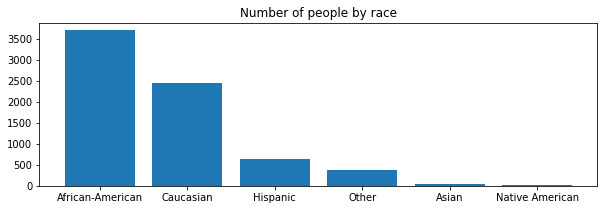

In [14]:
#Number of people by race
histo = data1["race"].value_counts()
y = histo.to_numpy()
plt.figure(figsize=(10, 3))
plt.bar(histo.keys(),y)
plt.title("Number of people by race")
plt.show()

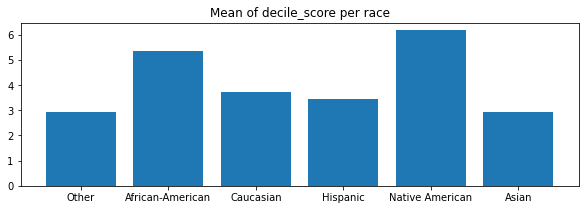

In [18]:
#Mean of decile_score per race
unique_races = data1.race.unique()
score_races = []
for i in unique_races:
  score_races.append(data1.loc[data1['race'] == i].decile_score.mean())

plt.figure(figsize=(10, 3))
plt.bar(unique_races,score_races)
plt.title("Mean of decile_score per race")
plt.show()

     Distribution of decile_score per race



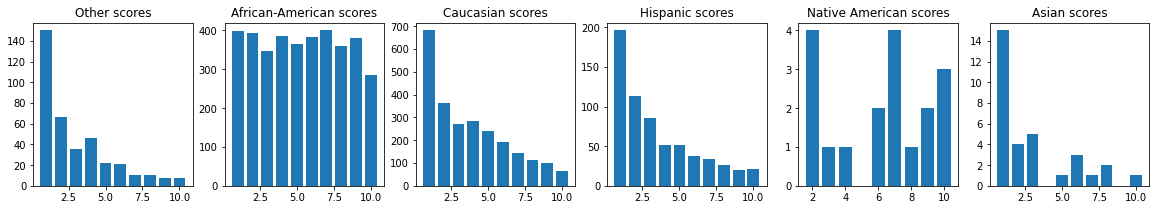

In [21]:
#Distribution of decile_score per race
unique_races = data1.race.unique()
print("     Distribution of decile_score per race")
print("")
plt.figure(figsize=(20, 3))
sp = 0
for i in unique_races: 
  data_series = data1.loc[data1['race'] == i].decile_score
  histo = data_series.value_counts()
  plt.subplot(161+sp)
  plt.bar(histo.keys(),histo.to_numpy())
  plt.title(i + " scores")
  sp+=1

   Recidivism rates by race



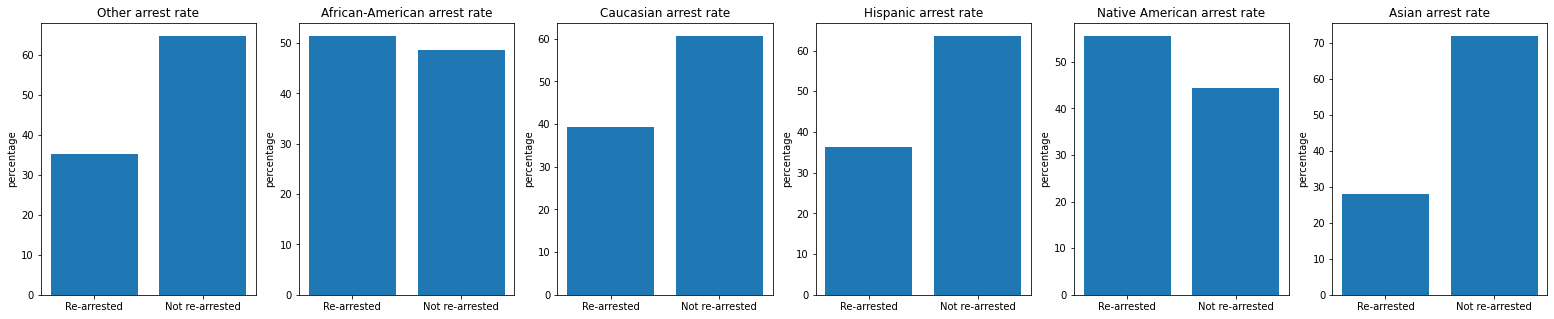

In [23]:
#Recidivism rates by race
race_count = data1["race"].value_counts()

print("   Recidivism rates by race")
print("")
plt.figure(figsize=(27, 5))
sp=0
for i in unique_races:
   num_arr = data1[(data1["race"] == i) & (data1['two_year_recid'] == 1)].shape[0]/race_count[i]*100
   num_not_arr = data1[(data1["race"] == i) & (data1['two_year_recid'] == 0)].shape[0]/race_count[i]*100
   plt.subplot(161+sp)
   plt.bar(['Re-arrested','Not re-arrested'],[num_arr,num_not_arr])
   plt.title(i + " arrest rate")
   plt.ylabel("percentage")
   sp+=1

COMPAS scores accuracy for Other is: 66.58% 
COMPAS scores accuracy for African-American is: 63.83% 
COMPAS scores accuracy for Caucasian is: 66.99% 
COMPAS scores accuracy for Hispanic is: 66.09% 
COMPAS scores accuracy for Native American is: 77.78% 
COMPAS scores accuracy for Asian is: 84.38% 


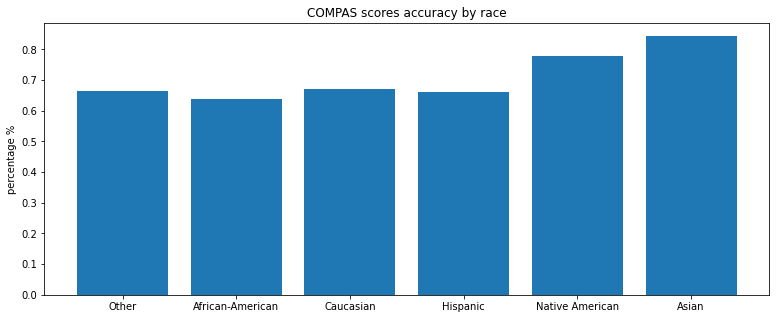

In [27]:
#COMPAS scores accuracy by race
compas_acc_c = []
compas_acc_dict = {}
for i in unique_races:
  compas_correct_p = data1.loc[(data1["decile_score"] > 4) & (data1["race"] == i) & (data1["two_year_recid"] == 1)].shape[0]
  compas_correct_n = data1.loc[(data1["decile_score"] <= 4) & (data1["race"] == i) & (data1["two_year_recid"] == 0)].shape[0]
  total_n_race = data1.loc[(data1["race"] == i)].shape[0]
  comp_acc_c = (compas_correct_p+compas_correct_n)/total_n_race
  compas_acc_c = compas_acc_c + [comp_acc_c]
  compas_acc_dict[i] = comp_acc_c
  print("COMPAS scores accuracy for %s is: %.2f%% " %(i,comp_acc_c*100))

plt.figure(figsize=(13, 5))
plt.bar(unique_races,compas_acc_c)
plt.ylabel("percentage %")
plt.title("COMPAS scores accuracy by race")
plt.show()

In [28]:
#False positive rates (FPR) for different races
compas_fpr_dict = {}
for i in unique_races:
  fp_compass = data1.loc[(data1["decile_score"] > 4) & (data1["race"] == i) & (data1["two_year_recid"] == 0)].shape[0]
  total_n_negatives_compass = data1.loc[(data1["two_year_recid"] == 0)].shape[0]
  fpr = fp_compass / total_n_negatives_compass
  compas_fpr_dict[i] = fpr
  print("FPR is: %.2f ------> %s" %(fpr,i))

FPR is: 0.01 ------> Other
FPR is: 0.20 ------> African-American
FPR is: 0.09 ------> Caucasian
FPR is: 0.02 ------> Hispanic
FPR is: 0.00 ------> Native American
FPR is: 0.00 ------> Asian


###Gender analysis
From the basic anaylsis we did on the genders in the dataset, we conclude the following: \\
1. The averages of decile_score for both genders are very close
2. Also the histogram of decile_score for both genders is very close
3. There are more male instances than female instances in the dataset. This also may introduce some kind of biasing towards one gender.
4. Males have a recidivism rate of about 48% while females have a recidivism rate of about 36%.
5. We found that the males FPR is 0.25 while females FPR is 0.07

   Mean of decile_score per gender


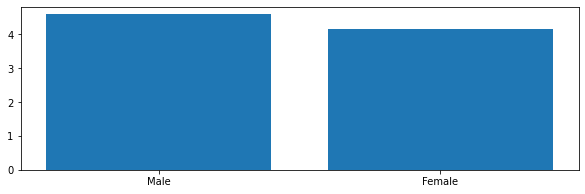

In [19]:
#Mean of decile_score per gender
unique_genders = data1.sex.unique()
score_races = []
for i in unique_genders:
  score_races.append(data1.loc[data1['sex'] == i].decile_score.mean())

print("   Mean of decile_score per gender")
plt.figure(figsize=(10, 3))
plt.bar(unique_genders,score_races)
plt.show()

     Distribution of decile_score per gender


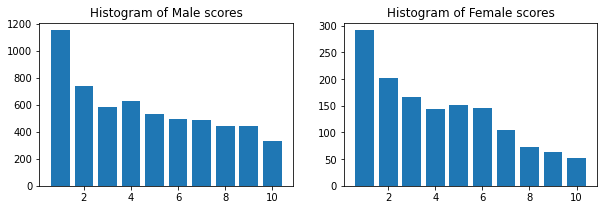

In [20]:
#Distribution of decile_score per gender
unique_genders = data1.sex.unique()

plt.figure(figsize=(10, 3))
sp = 0
for i in unique_genders: 
  data_series = data1.loc[data1['sex'] == i].decile_score
  histo = data_series.value_counts()
  plt.subplot(121+sp)
  plt.bar(histo.keys(),histo.to_numpy())
  plt.title("Histogram of " + i + " scores")
  sp+=1

print("     Distribution of decile_score per gender")

   Recidivism rates by gender



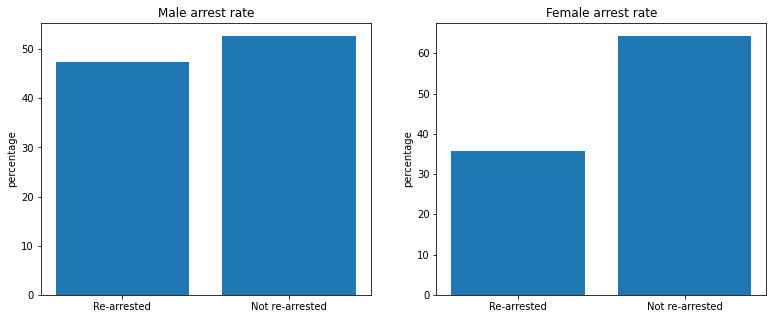

In [24]:
#Recidivism rates by gender
gender_count = data1["sex"].value_counts()

print("   Recidivism rates by gender")
print("")
plt.figure(figsize=(13, 5))
sp=0
for i in unique_genders:
   num_arr = data1[(data1["sex"] == i) & (data1['two_year_recid'] == 1)].shape[0]/gender_count[i]*100
   num_not_arr = data1[(data1["sex"] == i) & (data1['two_year_recid'] == 0)].shape[0]/gender_count[i]*100
   plt.subplot(121+sp)
   plt.bar(['Re-arrested','Not re-arrested'],[num_arr,num_not_arr])
   plt.title(i + " arrest rate")
   plt.ylabel("percentage")
   sp+=1

COMPAS scores accuracy for Male is: 65.37% 
COMPAS scores accuracy for Female is: 65.38% 


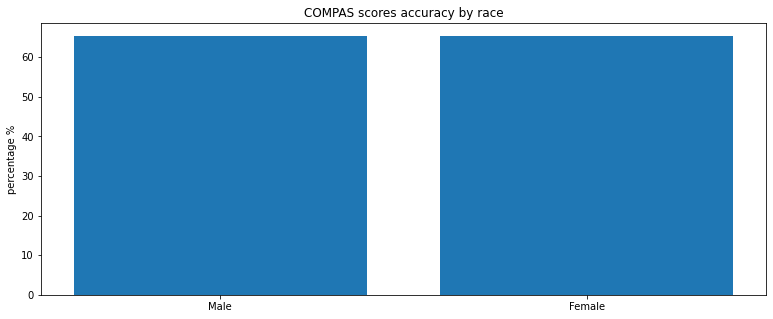

In [26]:
#COMPAS scores accuracy by gender
compas_acc_c = []
for i in unique_genders:
  compas_arrest_numc = (data1[(data1["decile_score"] > 4) & (data1["sex"] == i)])["two_year_recid"].value_counts()
  compas_no_arrest_numc = (data1[(data1["decile_score"] <= 4) & (data1["sex"] == i)])["two_year_recid"].value_counts()
  compas_pred_correctc = compas_arrest_numc[1] + compas_no_arrest_numc[0]
  compas_pred_wrongc = compas_arrest_numc[0] + compas_no_arrest_numc[1]
  comp_acc = (compas_pred_correctc/(compas_pred_correctc+compas_pred_wrongc))*100
  compas_acc_c = compas_acc_c + [comp_acc]
  print("COMPAS scores accuracy for %s is: %.2f%% " %(i,comp_acc))

plt.figure(figsize=(13, 5))
plt.bar(unique_genders,compas_acc_c)
plt.ylabel("percentage %")
plt.title("COMPAS scores accuracy by race")
plt.show()

In [55]:
#False positive rates (FPR) for different genders
compas_fpr_dict = {}
for i in unique_genders:
  fp_compass = data1.loc[(data1["decile_score"] > 4) & (data1["sex"] == i) & (data1["two_year_recid"] == 0)].shape[0]
  total_n_negatives_compass = data1.loc[(data1["two_year_recid"] == 0)].shape[0]
  fpr = fp_compass / total_n_negatives_compass
  compas_fpr_dict[i] = fpr
  print("FPR is: %.2f ------> %s" %(fpr,i))

FPR is: 0.25 ------> Male
FPR is: 0.07 ------> Female


###Other analysis
1. The dataset is somehow uniformly distributed in terms of the "two_year_recid" label 
2. The overall COMPAS accuracy is about 65%

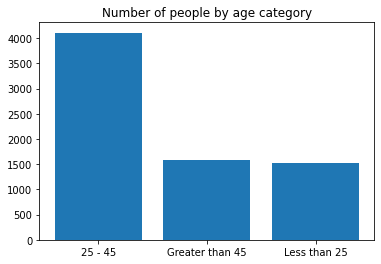

In [15]:
#Number of people by age category
histo = data1["age_cat"].value_counts()
plt.bar(histo.keys(),histo.to_numpy())
plt.title("Number of people by age category")
plt.show()

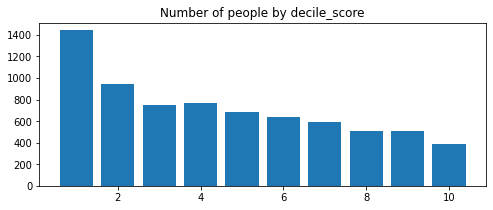

In [16]:
#Number of people by decile_score
histo = data1["decile_score"].value_counts()
plt.figure(figsize=(8, 3))
plt.bar(histo.keys(),histo.to_numpy())
plt.title("Number of people by decile_score")
plt.show()

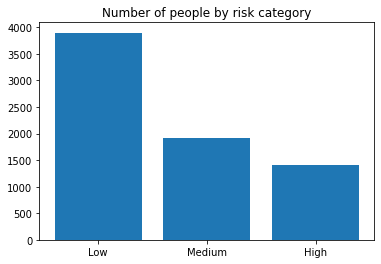

In [17]:
#Number of people by risk category
histo = data1["score_text"].value_counts()
plt.bar(histo.keys(),histo.to_numpy())
plt.title("Number of people by risk category")
plt.show()

In [22]:
#Number of people re-arrested
num_recid2 = dict(((data1["two_year_recid"] == 1).value_counts()))
print("Number of people re-arrested in two years is:",num_recid2[True])
print("Number of people not re-arrested in two years is:",num_recid2[False])

Number of people re-arrested in two years is: 3251
Number of people not re-arrested in two years is: 3963


In [25]:
#COMPAS scores overall accuracy
compas_arrest_num = (data1[data1["decile_score"] > 4])["two_year_recid"].value_counts()
compas_no_arrest_num = (data1[data1["decile_score"] <= 4])["two_year_recid"].value_counts()
compas_pred_correct = compas_arrest_num[1] + compas_no_arrest_num[0]
compas_pred_wrong = compas_arrest_num[0] + compas_no_arrest_num[1]
compas_acc = compas_pred_correct/(compas_pred_correct+compas_pred_wrong)
print("COMPAS scores accuracy is: %.2f%% " %(compas_acc*100))

COMPAS scores accuracy is: 65.37% 


###Comparing correlation of different attributes to the races/decile_score

####Correlating dataset attributes with race
Since being Caucasian has the value 1 and being not Caucasian has the value 0,
we can observe the following: \\
1. **Being a Caucasian** and **priors_count=0** are somehow correlated \\
2. **Being not Caucasian** and **having juventile records** are a bit correlated \\
3. **Being not Caucasian** and having **prior_count>3** are correlated \\
All of these can be the reason for the bias of the dataset towards Caucasians \\

On the other hand, we can see that the **two-year recidivism** and being **non Caucasian ** are somehow correlated which may explain one of the reasons that the machine learning models predicts non Caucasians to recidivate more than Caucasians.

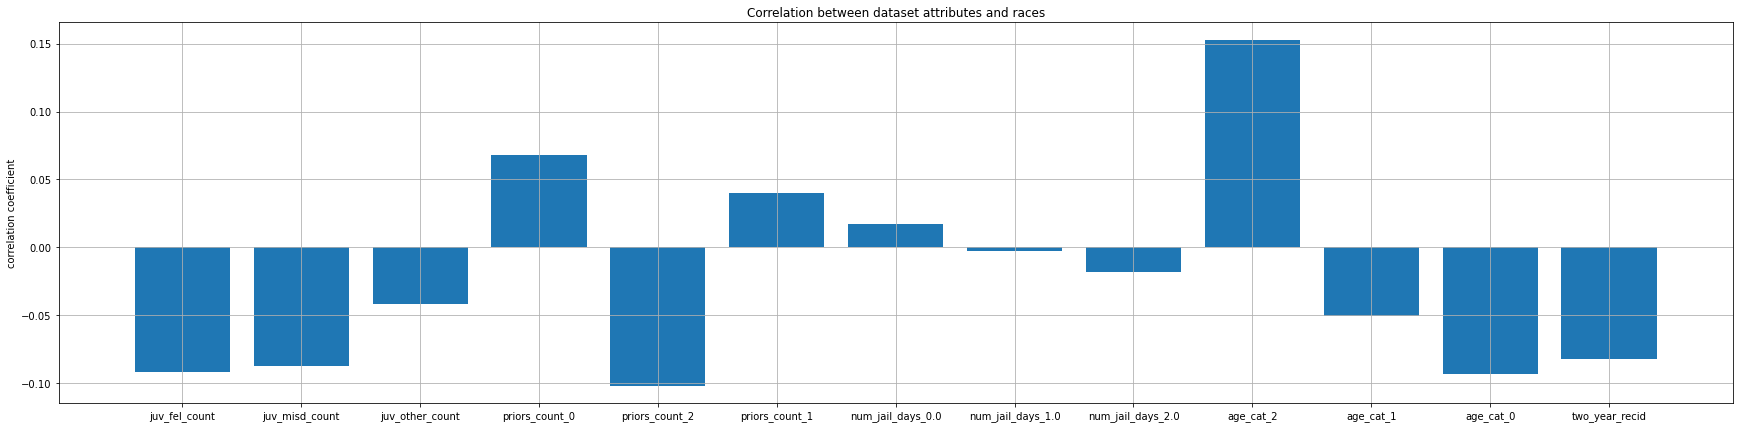

In [53]:
correlation = {}
for i in data.columns:
  if i != 'race' and i !='c_charge_degree' and i!='sex':
    correlation[i] = np.corrcoef(data[i],data['race']).min()

plt.figure(figsize=(30, 7))
plt.bar(correlation.keys(),correlation.values())
plt.grid(True)
plt.title("Correlation between dataset attributes and races")
plt.ylabel('correlation coefficient')
plt.show()

####Correlating dataset attributes with decile_score
Since being Caucasian has the value 1 and being not Caucasian has the value 0, we can observe the following: \\
1. **Being a non-Caucasian** is correlated with having **high decile_score**.
2. **Being less than 25 years old** is correlated with having **high decile_score**

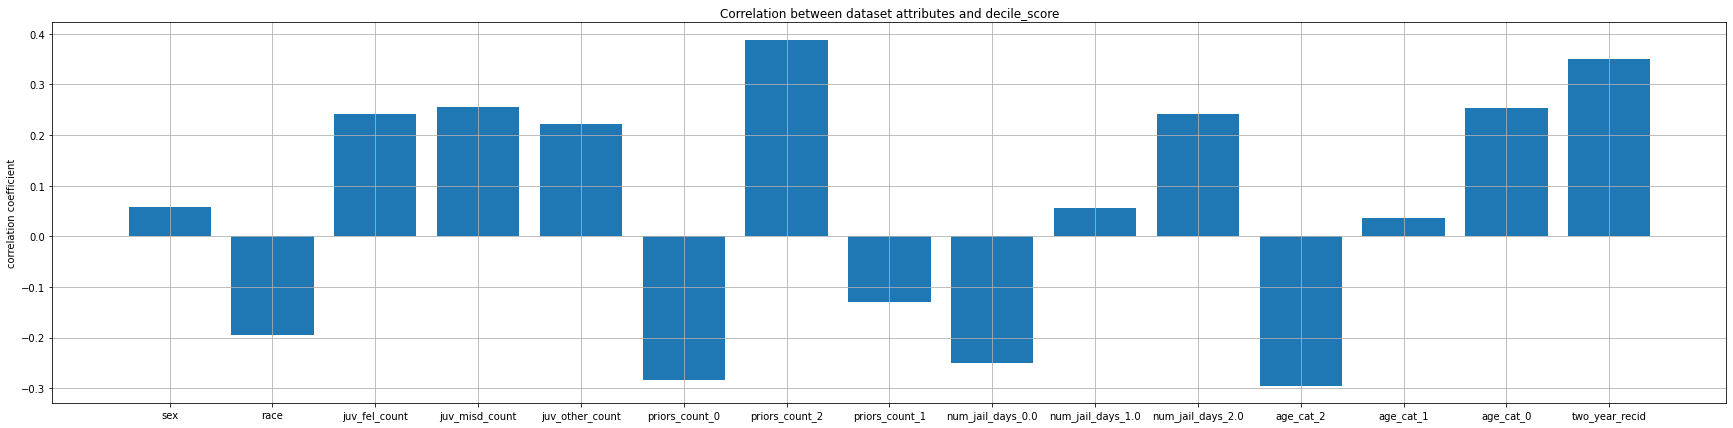

In [54]:
correlation2 = {}
for i in data.columns:
  if i != 'decile_score' and i !='c_charge_degree':
    correlation2[i] = np.corrcoef(data[i],data1['decile_score']).min()

plt.figure(figsize=(30, 7))
plt.bar(correlation2.keys(),correlation2.values())
plt.grid(True)
plt.title("Correlation between dataset attributes and decile_score")
plt.ylabel('correlation coefficient')
plt.show()

##(4) Building classifiers

###Multi-layer Perceptron
We trained a MLP perceptron with two dense layers, each layer has 20 neurons. We used binary crossentropy loss along with Adam optimizer. \\
1. We got a total accuracy of about 70%
2. The FPR for non-Caucasians is 0.26 while the FPR for Caucasians is 0.17. The classifier is still biased towards Caucasians. 



In [29]:
input_shape = xtrain.shape[1]

#MLP
model = Sequential()
model.add(Dense(20,activation='relu',input_dim=input_shape))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(xtrain,ytrain,16,8,validation_data=(xtest,ytest))
loss_test, acc_test = model.evaluate(xtest,ytest)
ypred = model.predict(xtest)
print("Test accuracy is: %.2f %%" %(acc_test*100))
#plot_acc(history)

Epoch 1/8
384/384 [==============================] - 1s 2ms/step - loss: 0.6409 - accuracy: 0.6382 - val_loss: 0.5999 - val_accuracy: 0.6851
Epoch 2/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6163 - accuracy: 0.6663 - val_loss: 0.5978 - val_accuracy: 0.6870
Epoch 3/8
384/384 [==============================] - 1s 2ms/step - loss: 0.6138 - accuracy: 0.6705 - val_loss: 0.5960 - val_accuracy: 0.6879
Epoch 4/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6129 - accuracy: 0.6694 - val_loss: 0.5977 - val_accuracy: 0.6888
Epoch 5/8
384/384 [==============================] - 1s 2ms/step - loss: 0.6120 - accuracy: 0.6704 - val_loss: 0.5972 - val_accuracy: 0.6925
Epoch 6/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6108 - accuracy: 0.6720 - val_loss: 0.5955 - val_accuracy: 0.6981
Epoch 7/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6109 - accuracy: 0.6722 - val_loss: 0.5976 - val_accuracy: 0.6981
Epoch 8/8
34/

In [30]:
#calculating accuracy manually
ypred2 = ypred > 0.5
ypred_mlp = ypred.copy()
ytest2 = np.array(ytest, dtype=bool)
ypred2 = ypred2.reshape((-1,1))
ytest2 = ytest2.reshape((-1,1))
corr = np.count_nonzero(ypred2 == ytest2)
acc = corr/ytest2.shape[0]
print("Test accuracy is: %.2f%%" %(acc*100))

Test accuracy is: 69.71%


In [31]:
mlp_acc_dict = {}
mlp_fpr_dict = {}
unique_races_mod = ['Not Caucasian','Caucasian']
for i in range(len(unique_races_mod)):
  argss = np.argwhere(xtest[:,1]==i)
  ypred3 = ypred2[argss]
  ytest3 = ytest2[argss]
  acc, fpr = compute_fpr(ypred3,ytest3)
  mlp_acc_dict[i] = acc
  mlp_fpr_dict[i] = fpr
  print("Accuracy is %.2f and FPR is %.2f for %s" %(acc,fpr,unique_races_mod[i]))

Accuracy is 0.69 and FPR is 0.26 for Not Caucasian
Accuracy is 0.71 and FPR is 0.17 for Caucasian


###K-nearest neighbors
We trained a K-nearest neighbor classifier with K=21 \\
1. We got a total accuracy of about 67.5%
2. The FPR for non-Caucasians is 0.32 while the FPR for Caucasians is 0.17 \\
The classifier is still biased towards Caucasians. 

In [32]:
model_knn = KNeighborsClassifier(n_neighbors=21)
model_knn.fit(xtrain,ytrain)
acc_knn = model_knn.score(xtest,ytest)
print("Test accuracy is: %.2f%%" %(acc_knn*100))

Test accuracy is: 67.50%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [33]:
#calculating accuracy and FPR for each race
ypred2 = model_knn.predict(xtest)
knn_acc_dict = {}
knn_fpr_dict = {}
ypred2 = ypred2.reshape((-1,1))
ytest2 = ytest2.reshape((-1,1))
unique_races_mod = ['Not Caucasian','Caucasian']
for i in range(len(unique_races_mod)):
  argss = np.argwhere(xtest[:,1]==i)
  ypred3 = ypred2[argss]
  ytest3 = ytest2[argss]
  acc, fpr = compute_fpr(ypred3,ytest3)
  knn_acc_dict[i] = acc
  knn_fpr_dict[i] = fpr
  print("Accuracy is %.3f and FPR is %.3f for %s" %(acc,fpr,unique_races_mod[i]))

Accuracy is 0.676 and FPR is 0.322 for Not Caucasian
Accuracy is 0.673 and FPR is 0.165 for Caucasian


###Logistic Regression
We trained a Logistic Regression classifier \\
1. We got a total accuracy of about 69.62%
2. The FPR for non-Caucasians is 0.29 while the FPR for Caucasians is 0.20 \\
The classifier is still biased towards Caucasians. 

In [34]:
model_lreg = LogisticRegression()
model_lreg.fit(xtrain, ytrain) 
acc_lreg = model_lreg.score(xtest,ytest)
print("Test accuracy is: %.2f%%" %(acc_lreg*100))

Test accuracy is: 69.62%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
#calculating accuracy and FPR for each race
ypred2 = model_lreg.predict(xtest)
lreg_acc_dict = {}
lreg_fpr_dict = {}
ypred2 = ypred2.reshape((-1,1))
ytest2 = ytest2.reshape((-1,1))
unique_races_mod = ['Not Caucasian','Caucasian']
for i in range(len(unique_races_mod)):
  argss = np.argwhere(xtest[:,1]==i)
  ypred3 = ypred2[argss]
  ytest3 = ytest2[argss]
  acc, fpr = compute_fpr(ypred3,ytest3)  
  lreg_acc_dict[i] = acc
  lreg_fpr_dict[i] = fpr
  print("Accuracy is %.3f and FPR is %.3f for %s" %(acc,fpr,unique_races_mod[i]))

Accuracy is 0.689 and FPR is 0.285 for Not Caucasian
Accuracy is 0.710 and FPR is 0.199 for Caucasian


###Decision Tree
We trained a Decision Tree classifier \\
1. We got a total accuracy of about 68.14%
2. The FPR for non-Caucasians is 0.28 while the FPR for Caucasians is 0.19 \\
The classifier is still biased towards Caucasians. 

In [36]:
model_tree = DecisionTreeClassifier(random_state=0)
model_tree.fit(xtrain,ytrain)
acc_tree = model_tree.score(xtest,ytest)
print("Test accuracy is: %.2f%%" %(acc_tree*100))

Test accuracy is: 68.14%


In [37]:
#calculating accuracy and FPR for each race
ypred2 = model_tree.predict(xtest)
tree_acc_dict = {}
tree_fpr_dict = {}
ypred2 = ypred2.reshape((-1,1))
ytest2 = ytest2.reshape((-1,1))
unique_races_mod = ['Not Caucasian','Caucasian']
for i in range(len(unique_races_mod)):
  argss = np.argwhere(xtest[:,1]==i)
  ypred3 = ypred2[argss]
  ytest3 = ytest2[argss]
  acc, fpr = compute_fpr(ypred3,ytest3)    
  tree_acc_dict[i] = acc
  tree_fpr_dict[i] = fpr
  print("Accuracy is %.2f and FPR is %.2f for %s" %(acc,fpr,unique_races_mod[i]))

Accuracy is 0.67 and FPR is 0.28 for Not Caucasian
Accuracy is 0.70 and FPR is 0.19 for Caucasian


##(5) Classification Fairness

###Removing race from attributes
When training MLP and Decision Tree models with the same data but removing the race from the attributes, we got also an unfair classifier which has less False Positive Rate (FPR) for Caucasians than other non-Caucasians. \\
This was expected as we may have other attributes which have values that are implicitly affected by the race attribute based on the human factor. This was somehow mentioned in the analysis part.


In [0]:
#removing race from attributes
races_array_train = xtrain[:,1]
races_array_test = xtest[:,1]
xtrain2 = np.delete(xtrain,1,axis=1)
xtest2 = np.delete(xtest,1,axis=1)

In [39]:
#MLP
input_shape = xtrain2.shape[1]

model = Sequential()
model.add(Dense(20,activation='relu',input_dim=input_shape))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(xtrain2,ytrain,16,8,validation_data=(xtest2,ytest))
loss_test, acc_test = model.evaluate(xtest2,ytest)
ypred = model.predict(xtest2)
print("Test accuracy is: %.2f %%" %(acc_test*100))
#plot_acc(history)

Epoch 1/8
384/384 [==============================] - 1s 2ms/step - loss: 0.6468 - accuracy: 0.6319 - val_loss: 0.6046 - val_accuracy: 0.6907
Epoch 2/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6197 - accuracy: 0.6658 - val_loss: 0.5978 - val_accuracy: 0.6944
Epoch 3/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6176 - accuracy: 0.6681 - val_loss: 0.5978 - val_accuracy: 0.6925
Epoch 4/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6165 - accuracy: 0.6722 - val_loss: 0.5962 - val_accuracy: 0.6990
Epoch 5/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6150 - accuracy: 0.6681 - val_loss: 0.5956 - val_accuracy: 0.6879
Epoch 6/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6133 - accuracy: 0.6704 - val_loss: 0.5969 - val_accuracy: 0.6962
Epoch 7/8
384/384 [==============================] - 1s 1ms/step - loss: 0.6141 - accuracy: 0.6705 - val_loss: 0.5959 - val_accuracy: 0.6925
Epoch 8/8
34/

In [40]:
#calculating accuracy and FPR for each race using MLP model
co=0
ypred2 = ypred > 0.5
ytest2 = np.array(ytest, dtype=bool)
mlp_acc_dict_no_race = {}
mlp_fpr_dict_no_race = {}
print("Calculating accuracy and FPR for each race using MLP model")
ypred2 = ypred2.reshape((-1,1))
ytest2 = ytest2.reshape((-1,1))
unique_races_mod = ['Not Caucasian','Caucasian']
for i in range(len(unique_races_mod)):
  argss = np.argwhere(xtest[:,1]==i)
  ypred3 = ypred2[argss]
  ytest3 = ytest2[argss]
  acc, fpr = compute_fpr(ypred3,ytest3)
  mlp_acc_dict_no_race[i] = acc
  mlp_fpr_dict_no_race[i] = fpr
  #st_print = start + "Accuracy is %.2f and FPR is %.2f for %s" + end
  #print(st_print %(acc,fpr,i))
  print("Accuracy is %.2f and FPR is %.2f for %s" %(acc,fpr,unique_races_mod[i]))

Calculating accuracy and FPR for each race using MLP model
Accuracy is 0.69 and FPR is 0.28 for Not Caucasian
Accuracy is 0.70 and FPR is 0.21 for Caucasian


In [41]:
#Decision Trees
model_tree = DecisionTreeClassifier(random_state=0)
model_tree.fit(xtrain2,ytrain)
acc_tree = model_tree.score(xtest2,ytest)
print("Test accuracy is: %.2f%%" %(acc_tree*100))

Test accuracy is: 67.50%


In [42]:
#calculating accuracy and FPR for each race using Desicion Tree model
ypred2 = model_tree.predict(xtest2)
co=0
tree_acc_dict_no_race = {}
tree_fpr_dict_no_race = {}
print("Calculating accuracy and FPR for each race using Decision Tree model")
ypred2 = ypred2.reshape((-1,1))
ytest2 = ytest2.reshape((-1,1))
unique_races_mod = ['Not Caucasian','Caucasian']
for i in range(len(unique_races_mod)):
  argss = np.argwhere(xtest[:,1]==i)
  ypred3 = ypred2[argss]
  ytest3 = ytest2[argss]
  acc, fpr = compute_fpr(ypred3,ytest3)
  tree_acc_dict_no_race[i] = acc
  tree_fpr_dict_no_race[i] = fpr
  #st_print = start + "Accuracy is %.2f and FPR is %.2f for %s" + end
  #print(st_print %(acc,fpr,i))
  print("Accuracy is %.2f and FPR is %.2f for %s" %(acc,fpr,unique_races_mod[i]))

Calculating accuracy and FPR for each race using Decision Tree model
Accuracy is 0.67 and FPR is 0.27 for Not Caucasian
Accuracy is 0.69 and FPR is 0.20 for Caucasian


###Mitigating bias using post-processing separation technique (Reject Option Classification - ROC)
We used the AIF360 package developped by IBM to test the algorithm of mitigating the bias in our COMPAS dataset. In this phase, all we care about is having a fair enough classifier while maintaing the same value range of the accuracy as much as possible. \\

We noticed that the difference between the FPRs of Caucasians and non-Caucasians dropped alot but on the other hand, this affected the accuracy which also dropped.

In [56]:
#visualizing the dataset
data.tail()

,sex,race,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,priors_count_0,priors_count_2,priors_count_1,num_jail_days_0.0,num_jail_days_1.0,num_jail_days_2.0,age_cat_2,age_cat_1,age_cat_0,two_year_recid
7209,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7210,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7211,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7212,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [0]:
#putting the dataset in to the right format to be used by aif360 package
data_aif = ad.StandardDataset(data,'two_year_recid',favorable_classes=[1.0],protected_attribute_names=['race'],privileged_classes=[lambda x: x == 1.0])

In [0]:
#splitting dataset
dataset_train, dataset_vt = data_aif.split([0.8], shuffle=True)
dataset_test, dataset_valid = dataset_vt.split([0.5], shuffle=True)

#defining that privilged_groups will have value 1 in and unprivilged_groups will have value 0 in race attribute
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

#metric_orig_train = BinaryLabelDatasetMetric(dataset_train, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
#print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [59]:
#Separating attributes from labels
xtrain_aif = dataset_train.features
ytrain_aif = dataset_train.labels
xvalid_aif = dataset_valid.features
yvalid_aif = dataset_valid.labels
xtest_aif = dataset_test.features
ytest_aif = dataset_test.labels

#Applying Logistic Regression
lmod = LogisticRegression()
lmod.fit(xtrain_aif, ytrain_aif)
ypredv_aif_before = lmod.predict_proba(xvalid_aif)[:,1]
ypredt_aif_before = lmod.predict_proba(xtest_aif)[:,1]

#Getting best achievable accuracy with certain threshold 
num_thresh = 100
threshs = np.linspace(0.01,0.99,num_thresh)
accuracies = []
for i, thresh in enumerate(threshs):
  ypredv_label_before = ypredv_aif_before > thresh
  ypredv_label_before = ypredv_label_before.reshape((-1,1))
  yvalid_aif = yvalid_aif.reshape((-1,1))
  num_corr = np.count_nonzero(ypredv_label_before == yvalid_aif)
  accuracies = accuracies + [num_corr/ypredv_label_before.shape[0]]

acc_argmax = np.argmax(accuracies)
best_thresh = threshs[acc_argmax]
print('Best classification accuracy on validation set is %.2f%% can be achieved at threshold equal to %.3f' %(accuracies[acc_argmax]*100,best_thresh))

Best classification accuracy on validation set is 68.56% can be achieved at threshold equal to 0.515


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
ROC, dataset_valid_pred = ROC_postprocess(dataset_train,dataset_valid,dataset_test,lmod,unprivileged_groups,privileged_groups)

In [64]:
#predicting for test set
dataset_test_pred = dataset_test.copy(deepcopy=True)
dataset_test_pred.scores = lmod.predict_proba(xtest_aif)[:,1].reshape(-1,1)

#putting favourable labels to positive instances
fav_inds = dataset_test_pred.scores > best_thresh
dataset_test_pred.labels[fav_inds] = dataset_test_pred.favorable_label
dataset_test_pred.labels[~fav_inds] = dataset_test_pred.unfavorable_label

#Changing labels of test set
dataset_test_pred_trans = ROC.predict(dataset_test_pred)
ypredt_aif_trans = dataset_test_pred_trans.labels

classif_metric_test = ClassificationMetric(dataset_test, dataset_test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
classif_metric_test_trans = ClassificationMetric(dataset_test, dataset_test_pred_trans, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

#Metrics using package
print("Accuracy before transformation is %.2f%%" %(classif_metric_test.accuracy()*100))
print("Accuracy after transformation is %.2f%%" %(classif_metric_test_trans.accuracy()*100))
print("FPR before transformation is %.2f" %(classif_metric_test.false_positive_rate()))
print("FPR after transformation is %.3f" %(classif_metric_test_trans.false_positive_rate()))

Accuracy before transformation is 69.21%
Accuracy after transformation is 59.78%
FPR before transformation is 0.21
FPR after transformation is 0.007


In [63]:
#Calculating new FPRs and accuracies after transformation
ypred_trans, ytest_aif = ypredt_aif_trans.reshape((-1,1)), ytest_aif.reshape((-1,1))
args_priv, args_unpriv = np.argwhere(xtest_aif[:,1]==1), np.argwhere(xtest_aif[:,1]==0)
ypred_priv, ypred_unpriv = ypred_trans[args_priv].reshape((-1,1)), ypred_trans[args_unpriv].reshape((-1,1))
ytest_priv, ytest_unpriv = ytest_aif[args_priv].reshape((-1,1)), ytest_aif[args_unpriv].reshape((-1,1))
acc_priv, fpr_priv = compute_fpr(ypred_priv,ytest_priv)
acc_unpriv, fpr_unpriv = compute_fpr(ypred_unpriv,ytest_unpriv)
print("Accuracy of Caucasians is %.2f%% and FPR is %.3f" %(acc_priv*100,fpr_priv))
print("Accuracy of Non Caucasians is %.2f%% and FPR is %.3f" %(acc_unpriv*100,fpr_unpriv))

acc_trans, fpr_trans = compute_fpr(ypred_trans,ytest_aif)
print("Overall accuracy is %.2f%% and overall FPR is %.3f" %(acc_trans*100,fpr_trans)) 

Accuracy of Caucasians is 64.57% and FPR is 0.006
Accuracy of Non Caucasians is 57.17% and FPR is 0.008
Overall accuracy is 59.78% and overall FPR is 0.007


##(6) Comparisons

###Comparing classifiers before applying fairness
We compared the performance metrics of the four classifiers we introduced before fairness: \\
1. KNN classifier was the only classifier that classified non-Caucasians with higher accuracy than Caucasians but on the other hand it was the most unfair classifier with a difference between the FPRs of about 0.16 
2. MLP, Logistic Regression and Decision Tree classifiers had FPR differences, of values (0.08,0.08,0.09), less than that of KNN .
3. COMPAS classifier had FPR difference of value 0.11 while three of our classifiers got less differences, of average 0.083, as indicated in point(2). We can see that these three classifiers are more fair than COMPAS classifier.

In [50]:
print("Accuracies of the four classifiers are: ")
print('Non-Caucasians: %.2f%%, Caucasians: %.2f%% using MLP' %(mlp_acc_dict[0]*100,mlp_acc_dict[1]*100))
print('Non-Caucasians: %.2f%%, Caucasians: %.2f%% using KNN' %(knn_acc_dict[0]*100,knn_acc_dict[1]*100))
print('Non-Caucasians: %.2f%%, Caucasians: %.2f%% using Logistic Regression' %(lreg_acc_dict[0]*100,lreg_acc_dict[1]*100))
print('Non-Caucasians: %.2f%%, Caucasians: %.2f%% using Decision Trees' %(tree_acc_dict[0]*100,tree_acc_dict[1]*100))
print("")
print("FPRs of the four classifiers are: ")
print('Non-Caucasians: %.2f, Caucasians: %.2f using MLP' %(mlp_fpr_dict[0],mlp_fpr_dict[1]))
print('Non-Caucasians: %.2f, Caucasians: %.2f using KNN' %(knn_fpr_dict[0],knn_fpr_dict[1]))
print('Non-Caucasians: %.2f, Caucasians: %.2f using Logistic Regression' %(lreg_fpr_dict[0],lreg_fpr_dict[1]))
print('Non-Caucasians: %.2f, Caucasians: %.2f using Decision Trees' %(tree_fpr_dict[0],tree_fpr_dict[1]))

Accuracies of the four classifiers are: 
Non-Caucasians: 68.87%, Caucasians: 71.31% using MLP
Non-Caucasians: 67.61%, Caucasians: 67.29% using KNN
Non-Caucasians: 68.87%, Caucasians: 71.05% using Logistic Regression
Non-Caucasians: 67.32%, Caucasians: 69.71% using Decision Trees

FPRs of the four classifiers are: 
Non-Caucasians: 0.26, Caucasians: 0.17 using MLP
Non-Caucasians: 0.32, Caucasians: 0.16 using KNN
Non-Caucasians: 0.28, Caucasians: 0.20 using Logistic Regression
Non-Caucasians: 0.28, Caucasians: 0.19 using Decision Trees


###Comparing Logistic Regression classifier predictions before and after fairness
We trained a Logistic Regression model as indicated before. We got its predictions to process it in order to have a fair classifier using Reject Option Classification (ROC) post-processing technique. We calculated the performance metrics for labels before and after applying the technique to see the difference in accuracy and FPR values. \\
1. The accuracy dropped from 69% to about 61% but the accuracy of Caucasians is more than the accuracy of non-Caucasians.
2. The FPR difference between both races dropped from 0.09 to 0.002 which now makes a more fair classifier.

In [66]:
print("Accuracies of Logistic Regression classifier before and after fairness")
print('Non-Caucasians: %.2f%%, Caucasians: %.2f%% before fairness' %(lreg_acc_dict[0]*100,lreg_acc_dict[1]*100))
print('Non-Caucasians: %.2f%%, Caucasians: %.2f%% after fairness' %(acc_unpriv*100,acc_priv*100))
print("")
print("FPRs of Logistic Regression classifier before and after fairness")
print('Non-Caucasians: %.3f, Caucasians: %.3f using Logistic Regression' %(lreg_fpr_dict[0],lreg_fpr_dict[1]))
print('Non-Caucasians: %.3f, Caucasians: %.3f after fairness' %(fpr_unpriv,fpr_priv))

Accuracies of Logistic Regression classifier before and after fairness
Non-Caucasians: 68.87%, Caucasians: 71.05% before fairness
Non-Caucasians: 57.17%, Caucasians: 64.57% after fairness

FPRs of Logistic Regression classifier before and after fairness
Non-Caucasians: 0.285, Caucasians: 0.199 using Logistic Regression
Non-Caucasians: 0.008, Caucasians: 0.006 after fairness


##(7) References
1. Solon Barocas, Moritz Hardt, and Arvind Narayanan. Fairness and Machine Learning. fairmlbook.org, 2019. http://www.fairmlbook.org
2. https://github.com/IBM/AIF360
3. https://github.com/propublica/compas-analysis
4. https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
